In [1]:
import pandas as pd
import xarray as xr
import numpy  as np
import matplotlib.pyplot as plt
from oggm import utils

In [2]:
dir_nc = '/home/www/oggm/gdirs/oggm_v1.4/L3-L5_files/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI62/b_080/L5/summary/'

In [3]:
dfnc = pd.read_csv(dir_nc + 'fixed_geometry_mass_balance_19.csv', index_col=0, low_memory=False).loc[2000:]

In [4]:
dir_wc = 'calving_output/'

In [5]:
dfs = pd.read_csv(dir_wc + 'glacier_statistics_19.csv', index_col=0, low_memory=False)

In [6]:
dfwc = pd.read_csv(dir_wc + 'fixed_geometry_mass_balance_19.csv', index_col=0, low_memory=False).loc[2000:]

In [7]:
dfs['smb_nc'] = dfnc.mean()
dfs['smb_wc'] = dfwc.mean()

In [8]:
dfmb = dfs[['rgi_area_km2', 'smb_nc', 'smb_wc']].copy().dropna()

## Compare calib Mass-balances (SMB and calving from inversion) 

In [9]:
# Compare with the reference geodetic MB
dfh = pd.read_csv(utils.get_demo_file('table_hugonnet_regions_10yr_20yr_ar6period.csv'))
dfh = dfh.loc[dfh.period == '2000-01-01_2020-01-01'].set_index('reg')
dfh['SMB_HUGUONNET'] = dfh['dmdtda']
dfh['SMB_HUGUONNET_err'] = dfh['err_dmdtda']
dfh.index = ['{:02d}'.format(rgi_reg) for rgi_reg in dfh.index]

In [10]:
dfh.SMB_HUGUONNET.loc['19'] # here we should get something close to -178.42 , but we don't exactly because I removed the glaciers which 

-166.49

In [11]:
np.average(dfmb.smb_nc, weights=dfmb.rgi_area_km2), np.average(dfmb.smb_wc, weights=dfmb.rgi_area_km2)

(-166.490001746384, 202.17051371362905)

OK SMB in non-calving case matches MB geod perfectly.

In [12]:
dfmb['calving_inversion'] = dfs.loc[dfmb.index].calving_flux.fillna(0) * 1e9 * 900 / (dfmb['rgi_area_km2'] * 1e6)

In [13]:
np.average(dfmb.smb_wc - dfmb.calving_inversion, weights=dfmb['rgi_area_km2'])

-166.4899990772531

OK so SMB - CALVING in calving case matches MB geod perfectly.

## Now the dynamical run 

In [14]:
with xr.open_dataset(dir_nc + 'historical_run_output_extended_19.nc') as ds:
    dsnc = ds.sel(time=slice(2000, 2019)).load()
with xr.open_dataset(dir_wc + 'historical_run_output_extended_19.nc') as ds:
    dswc = ds.sel(time=slice(2000, 2019)).load()

In [15]:
dsnc = dsnc.sel(rgi_id=dfmb.index)
dswc = dswc.sel(rgi_id=dfmb.index)

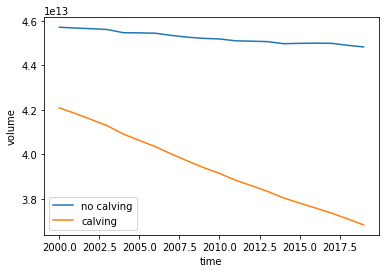

In [16]:
dsnc.volume.sum(dim='rgi_id').plot(label='no calving');
dswc.volume.sum(dim='rgi_id').plot(label='calving');
plt.legend();

In [17]:
area = dsnc.area.isel(time=0)
area = area.where(area > 0)
dmdtda = (dsnc.volume.isel(time=-1) - dsnc.volume.isel(time=0)) / area / len(dsnc.time) * 900 
np.average(dmdtda.dropna(dim='rgi_id'), weights=area.dropna(dim='rgi_id')) 

-298.8717

Not perfect but close enough...

In [18]:
area = dswc.area.isel(time=0)
area = area.where(area > 0)
dmdtda = (dswc.volume.isel(time=-1) - dswc.volume.isel(time=0)) / area / len(dsnc.time) * 900 
np.average(dmdtda.dropna(dim='rgi_id'), weights=area.dropna(dim='rgi_id')) 

-1920.3108

OK so that IS a problem - calving is much stronger after dynamics than after inversion ;-)